Описание полей данных

<ul>
<li>'year' - год производства</li>
<li>'make' - производитель</li>
<li>'model' - модель</li>
<li>'trim' - модификация</li>
<li>'body' - тип кузова</li>
<li>'transmission' - тип КПП</li>
<li>'vin' - идентификатор (вин)</li>
<li>'state' - штат регистрации</li>
<li>'condition' - состояние по шкале (1-5)</li>
<li>'odometer' - пробег в милях</li>
<li>'color' - цвет кузова</li>
<li>'interior' - цвет интерьера</li>
<li>'seller' - продавец</li>
<li>'sellingprice' - стоимость продажи</li>
<li>'saledate' - дата продажи</li>
</ul>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

pd.set_option('display.max_columns', None)

train_df.head()

display(train_df.info())

quant_vars = ['sellingprice', 'odometer']
display(train_df[quant_vars].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


None

,sellingprice,odometer
count,440236.000000,440167.000000
mean,13592.209588,68344.421604
std,9751.479098,53542.203908
min,1.000000,1.000000
25%,6900.000000,28258.000000
50%,12100.000000,52098.000000
75%,18200.000000,99272.000000
max,230000.000000,999999.000000


С ценами и пробегом явно что-то нет то, у нас большое стандартное отклонение по этим параметрам, построим boxplot и посмотрим на выбросы

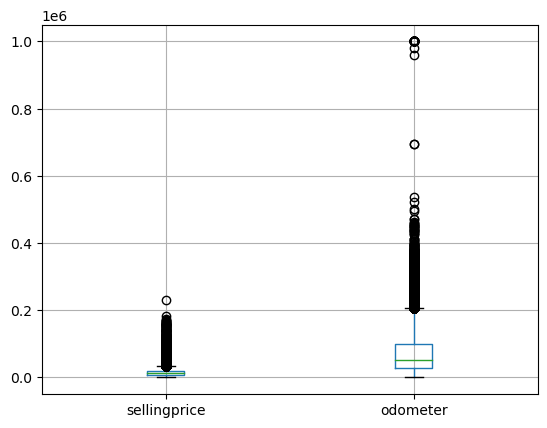

In [2]:
train_df.boxplot(column=quant_vars)
plt.show()

У нас есть выбросы в данных, надо бы посмотреть каков характер этих выбросов или посмотреть сколько выбросов от датасета и хватит ли у нас данных для обучения модели

In [3]:
lower_bounds = train_df[quant_vars].quantile(0.05)
upper_bounds = train_df[quant_vars].quantile(0.95)

filter_train_df = train_df.loc[    
    (train_df[quant_vars] >= lower_bounds).all(axis=1) & 
    (train_df[quant_vars] <= upper_bounds).all(axis=1)
]

print('Остается строк:', len(filter_train_df))

Остается строк: 366325


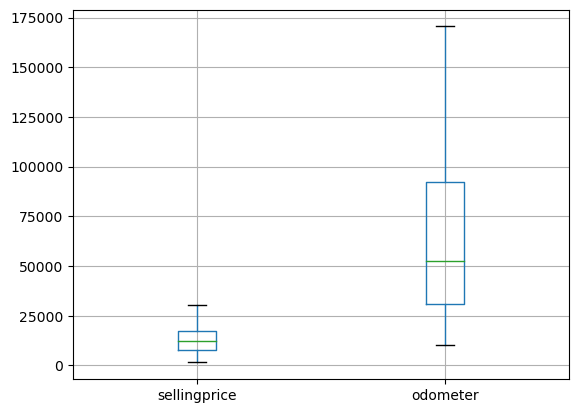

In [4]:
filter_train_df.boxplot(column=quant_vars)
plt.show()

In [5]:
train_df = filter_train_df

Для обчения модели нам Vin, Продавцы не нужны, думаю что его можно удалить, vin никак не влияет на стоимость, также думаю и продавцы стараются находиться в рынке

In [6]:
train_df = train_df.drop(columns=['vin', 'seller'])

### Работа со временем

In [7]:
test_df.at[14116, 'saledate'] = 'Tue Jan 13 2015 09:15:00 GMT-0800 (PST)'
train_df['saledate'] = pd.to_datetime(train_df['saledate'], utc=True)
test_df['saledate'] = pd.to_datetime(test_df['saledate'], utc=True)

In [8]:

train_df['sales_year'] = train_df['saledate'].dt.year
train_df['sales_month'] = train_df['saledate'].dt.month
train_df['sales_day'] = train_df['saledate'].dt.day
train_df['sales_weekday'] = train_df['saledate'].dt.weekday

In [9]:
test_df['sales_year'] = test_df['saledate'].dt.year
test_df['sales_month'] = test_df['saledate'].dt.month
test_df['sales_day'] = test_df['saledate'].dt.day
test_df['sales_weekday'] = test_df['saledate'].dt.weekday

In [10]:
def get_time_of_day(hour):
    if hour < 12:
        return 'morning'
    elif hour >= 12 and hour < 18:
        return 'afternoon'
    elif 18 <= hour < 22:
        return 'evening'
    else:
        return "night"
    
train_df['part_of_day'] = train_df['saledate'].dt.hour.apply(get_time_of_day)
test_df['part_of_day'] = test_df['saledate'].dt.hour.apply(get_time_of_day)


### Разбираемся с пропускам, дубликатами, неявными дубликатами

In [11]:
display(train_df.info())
test_df['odometer'] = test_df['odometer'].fillna(test_df.loc[~test_df['odometer'].isnull()]['odometer'].median())

cols_with_nulls = train_df.columns[train_df.isna().any()].tolist()
print(cols_with_nulls)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366325 entries, 0 to 440235
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   year           366325 non-null  int64              
 1   make           360732 non-null  object             
 2   model          360732 non-null  object             
 3   trim           360496 non-null  object             
 4   body           359141 non-null  object             
 5   transmission   324562 non-null  object             
 6   state          366325 non-null  object             
 7   condition      359775 non-null  float64            
 8   odometer       366325 non-null  float64            
 9   color          365947 non-null  object             
 10  interior       365947 non-null  object             
 11  sellingprice   366325 non-null  int64              
 12  saledate       366325 non-null  datetime64[ns, UTC]
 13  sales_year     366325 non-nul

None

['make', 'model', 'trim', 'body', 'transmission', 'condition', 'color', 'interior']


In [12]:
object_cols = train_df.select_dtypes(include='object').columns.tolist()

print(object_cols)

for item in object_cols:
    if train_df[item].dtype == 'object':
        train_df[item] = train_df[item].str.lower()
        test_df[item] = test_df[item].str.lower()


['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'part_of_day']


#### Заменяем NaN и '—'

In [13]:
train_df['condition'] = train_df['condition'].fillna(0)
train_df = train_df.fillna('undefined')

test_df['condition'] = test_df['condition'].fillna(0)
test_df = test_df.fillna('undefined')

train_df['interior'] = train_df['interior'].replace('—', 'undefined')
train_df['color'] = train_df['color'].replace('—', 'undefined')

test_df['interior'] = test_df['interior'].replace('—', 'undefined')
test_df['color'] = test_df['color'].replace('—', 'undefined')

In [14]:
def plot_pie_chart(df, column, title, figsize=(12, 8)):
    counts = df[column].value_counts()
    plt.pie(counts.values, labels=counts.index.tolist(), autopct='%1.1f%%',  figsize=figsize)
    plt.axis('equal')
    plt.title(title)
    plt.show()

def plot_mean_price_by_category(data, category_column, price_column, figsize=(12, 8)):
    # группируем данные по категории и находим среднюю цену для каждой категории
    grouped = data.groupby(category_column)[price_column].mean()

    # строим график
    grouped.plot(kind='bar', figsize=figsize)
    plt.xlabel(category_column)
    plt.ylabel('Mean ' + price_column)
    plt.show()

In [15]:
train_df.drop_duplicates(inplace=True);


In [16]:
train_df = train_df.rename(columns={"sellingprice": "selling_price", "saledate": "sale_date"})
train_df.head()


,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,selling_price,sale_date,sales_year,sales_month,sales_day,sales_weekday,part_of_day
0,2011,ford,edge,sel,suv,automatic,md,4.2,111041.0,black,black,12500,2015-06-01 19:30:00+00:00,2015,6,1,0,evening
1,2014,ford,fusion,se,sedan,automatic,mo,3.5,31034.0,black,black,14500,2015-02-24 18:00:00+00:00,2015,2,24,1,evening
2,2012,nissan,sentra,2.0 sl,sedan,automatic,nj,2.2,35619.0,black,black,9100,2015-06-09 19:30:00+00:00,2015,6,9,1,evening
3,2003,hummer,h2,base,suv,automatic,tx,2.8,131301.0,gold,beige,13300,2015-06-16 20:00:00+00:00,2015,6,16,1,evening
5,2013,lincoln,mkz,base,sedan,automatic,mi,2.5,14894.0,black,black,22600,2015-05-20 19:00:00+00:00,2015,5,20,2,evening


In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366325 entries, 0 to 440235
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   year           366325 non-null  int64              
 1   make           366325 non-null  object             
 2   model          366325 non-null  object             
 3   trim           366325 non-null  object             
 4   body           366325 non-null  object             
 5   transmission   366325 non-null  object             
 6   state          366325 non-null  object             
 7   condition      366325 non-null  float64            
 8   odometer       366325 non-null  float64            
 9   color          366325 non-null  object             
 10  interior       366325 non-null  object             
 11  selling_price  366325 non-null  int64              
 12  sale_date      366325 non-null  datetime64[ns, UTC]
 13  sales_year     366325 non-nul

Так, чтобы не кодировать все признаки, я в OHE или порядковое, я решил посмотреть какие признаки наиболее часто встречаются и каким образом они коррелируют с ценой

### Разведочный анализ

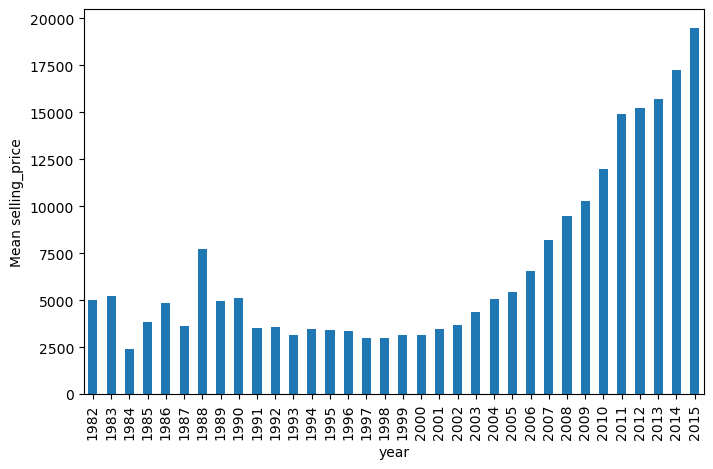

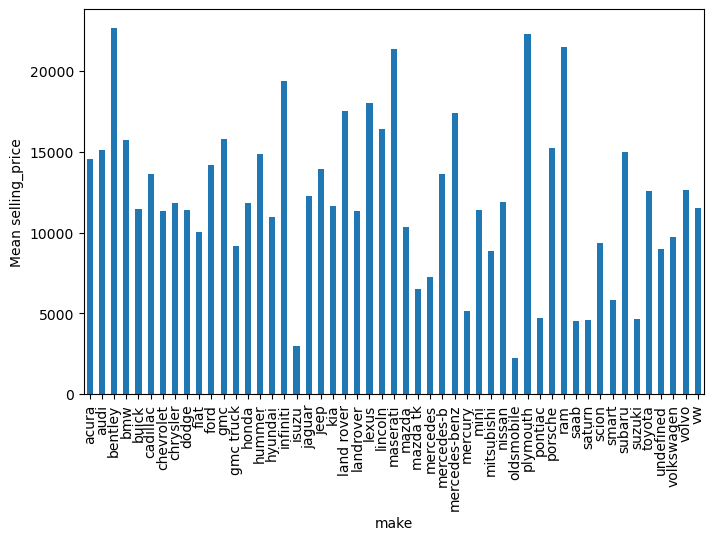

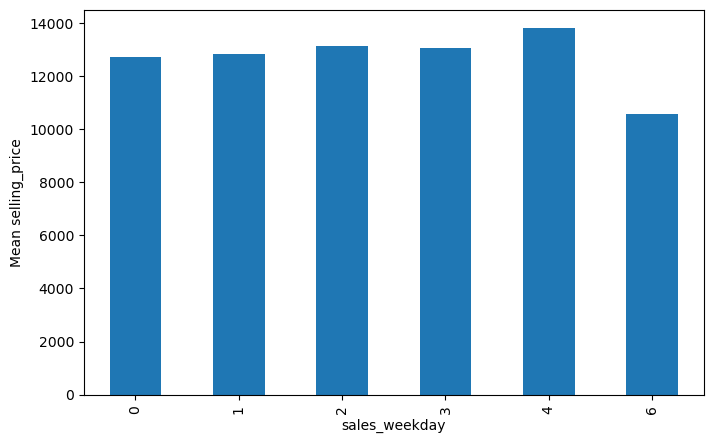

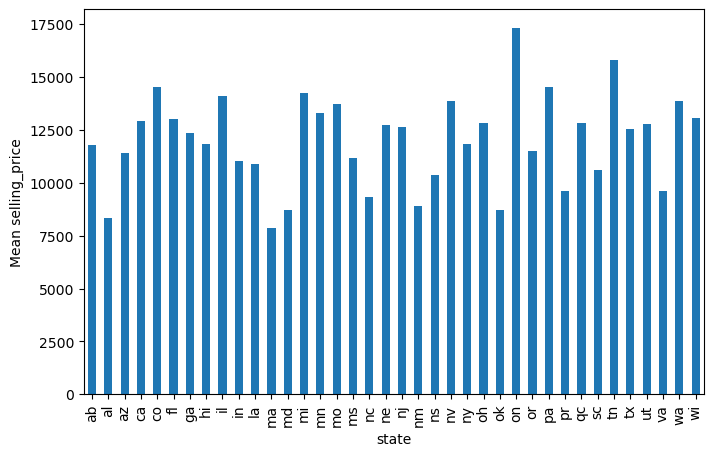

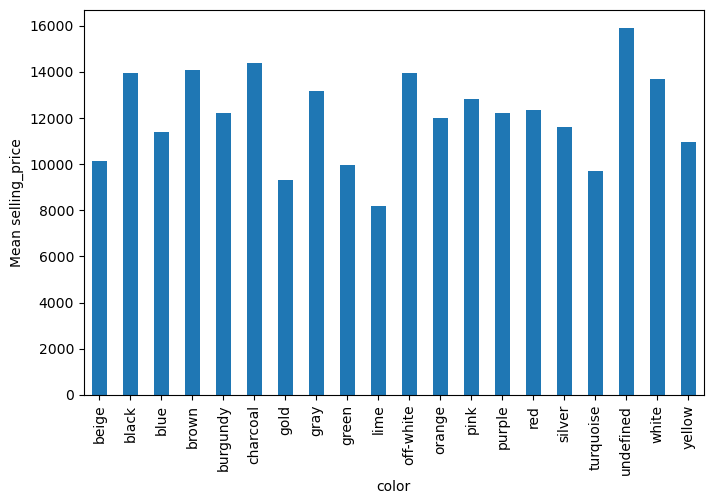

In [18]:
plot_mean_price_by_category(train_df, 'year', 'selling_price', figsize=(8, 5))
plot_mean_price_by_category(train_df, 'make', 'selling_price', figsize=(8, 5))
plot_mean_price_by_category(train_df, 'sales_weekday', 'selling_price', figsize=(8, 5))
plot_mean_price_by_category(train_df, 'state', 'selling_price', figsize=(8, 5))
plot_mean_price_by_category(train_df, 'color', 'selling_price', figsize=(8, 5))

In [19]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110060 entries, 0 to 110059
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   year           110060 non-null  int64              
 1   make           110060 non-null  object             
 2   model          110060 non-null  object             
 3   trim           110060 non-null  object             
 4   body           110060 non-null  object             
 5   transmission   110060 non-null  object             
 6   vin            110060 non-null  object             
 7   state          110060 non-null  object             
 8   condition      110060 non-null  float64            
 9   odometer       110060 non-null  float64            
 10  color          110060 non-null  object             
 11  interior       110060 non-null  object             
 12  seller         110060 non-null  object             
 13  saledate       110060 non-nul

### Кодируем признаки

In [20]:
rank_models = train_df.groupby('model')['selling_price'].mean().sort_values(ascending=False).reset_index()
rank_trim = train_df.groupby('trim')['selling_price'].mean().sort_values().reset_index()

bins = 80
rank_models['rank_model'] = pd.cut(rank_models['selling_price'], bins=bins, labels=list(range(1, bins + 1)))
rank_trim['rank_trim'] = pd.cut(rank_trim['selling_price'], bins=bins, labels=list(range(1, bins + 1)))

merged_df = train_df.merge(rank_models[['model', 'rank_model']], on='model', how='left')
merged_df = merged_df.merge(rank_trim[['trim', 'rank_trim']], on='trim', how='left')

merged_df.drop(columns=['model', 'trim', 'sale_date'], axis=1, inplace=True)

train_df = merged_df


In [21]:
merged_df = test_df.merge(rank_models[['model', 'rank_model']], on='model', how='left')
merged_df = merged_df.merge(rank_trim[['trim', 'rank_trim']], on='trim', how='left')

merged_df.drop(columns=['model', 'trim', 'saledate'], axis=1, inplace=True)
test_df = merged_df

In [22]:
train_df[['rank_model', 'rank_trim']] = train_df[['rank_model', 'rank_trim']].astype('int32')
test_df[['rank_model', 'rank_trim']] = test_df[['rank_model', 'rank_trim']].astype('object')

In [23]:
test_df[['rank_model', 'rank_trim']] = test_df[['rank_model', 'rank_trim']].fillna(0)

In [24]:
test_df[['rank_model', 'rank_trim']] = test_df[['rank_model', 'rank_trim']].astype('int32')

In [25]:
test_df.info()
test_price = pd.read_csv('./sample_submission.csv')

# test_price['sellingprice']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110060 entries, 0 to 110059
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   year           110060 non-null  int64  
 1   make           110060 non-null  object 
 2   body           110060 non-null  object 
 3   transmission   110060 non-null  object 
 4   vin            110060 non-null  object 
 5   state          110060 non-null  object 
 6   condition      110060 non-null  float64
 7   odometer       110060 non-null  float64
 8   color          110060 non-null  object 
 9   interior       110060 non-null  object 
 10  seller         110060 non-null  object 
 11  sales_year     110060 non-null  int64  
 12  sales_month    110060 non-null  int64  
 13  sales_day      110060 non-null  int64  
 14  sales_weekday  110060 non-null  int64  
 15  part_of_day    110060 non-null  object 
 16  rank_model     110060 non-null  int32  
 17  rank_trim      110060 non-nul

In [26]:
features_for_coding = [
    'rank_model', 'rank_trim', 'year', 'make', 'body', 'transmission', 'state', 'color', 'interior', 'sales_year', 'sales_month', 'sales_day', 'part_of_day',
]

train_df = pd.get_dummies(train_df, columns=features_for_coding, drop_first=True)
test_df = pd.get_dummies(test_df, columns=features_for_coding, drop_first=True)

train_df, test_df = train_df.align(test_df, join='outer', axis=1, fill_value=0)

In [27]:
target = train_df['selling_price']
features = train_df.drop(columns=['vin', 'seller', 'selling_price'], axis=1)

In [28]:
from sklearn.preprocessing import OneHotEncoder

numeric_columns = [
    'condition', 'odometer'
]

scaler = StandardScaler()
scaler.fit(features[numeric_columns])

features[numeric_columns] = scaler.transform(features[numeric_columns])
test_df[numeric_columns] = scaler.transform(test_df[numeric_columns])


features.head()

,body_beetle convertible,body_cab plus,body_cab plus 4,body_club cab,body_convertible,body_coupe,body_crew cab,body_crewmax cab,body_cts coupe,body_cts wagon,body_cts-v coupe,body_double cab,body_e-series van,body_elantra coupe,body_extended cab,body_g convertible,body_g coupe,body_g sedan,body_g37 convertible,body_g37 coupe,body_genesis coupe,body_granturismo convertible,body_hatchback,body_king cab,body_koup,body_mega cab,body_minivan,body_promaster cargo van,body_q60 convertible,body_q60 coupe,body_quad cab,body_regular cab,body_regular-cab,body_sedan,body_supercab,body_supercrew,body_suv,body_transit van,body_tsx sport wagon,body_undefined,body_van,body_wagon,body_xtracab,color_black,color_blue,color_brown,color_burgundy,color_charcoal,color_gold,color_gray,color_green,color_lime,color_off-white,color_orange,color_pink,color_purple,color_red,color_silver,color_turquoise,color_undefined,color_white,color_yellow,condition,interior_black,interior_blue,interior_brown,interior_burgundy,interior_gold,interior_gray,interior_green,interior_off-white,interior_orange,interior_purple,interior_red,interior_silver,interior_tan,interior_undefined,interior_white,interior_yellow,make_aston martin,make_audi,make_bentley,make_bmw,make_buick,make_cadillac,make_chev truck,make_chevrolet,make_chrysler,make_daewoo,make_dodge,make_ferrari,make_fiat,make_fisker,make_ford,make_ford tk,make_geo,make_gmc,make_gmc truck,make_honda,make_hummer,make_hyundai,make_hyundai tk,make_infiniti,make_isuzu,make_jaguar,make_jeep,make_kia,make_land rover,make_landrover,make_lexus,make_lincoln,make_lotus,make_maserati,make_mazda,make_mazda tk,make_mercedes,make_mercedes-b,make_mercedes-benz,make_mercury,make_mini,make_mitsubishi,make_nissan,make_oldsmobile,make_plymouth,make_pontiac,make_porsche,make_ram,make_rolls-royce,make_saab,make_saturn,make_scion,make_smart,make_subaru,make_suzuki,make_tesla,make_toyota,make_undefined,make_volkswagen,make_volvo,make_vw,odometer,part_of_day_evening,part_of_day_morning,part_of_day_night,rank_model_1,rank_model_10,rank_model_11,rank_model_12,rank_model_13,rank_model_14,rank_model_15,rank_model_16,rank_model_17,rank_model_18,rank_model_19,rank_model_2,rank_model_20,rank_model_21,rank_model_22,rank_model_23,rank_model_24,rank_model_25,rank_model_26,rank_model_27,rank_model_28,rank_model_29,rank_model_3,rank_model_30,rank_model_31,rank_model_32,rank_model_33,rank_model_34,rank_model_35,rank_model_36,rank_model_37,rank_model_38,rank_model_39,rank_model_4,rank_model_40,rank_model_41,rank_model_42,rank_model_43,rank_model_44,rank_model_45,rank_model_46,rank_model_47,rank_model_48,rank_model_49,rank_model_5,rank_model_50,rank_model_51,rank_model_52,rank_model_53,rank_model_54,rank_model_55,rank_model_56,rank_model_57,rank_model_58,rank_model_59,rank_model_6,rank_model_60,rank_model_61,rank_model_62,rank_model_63,rank_model_64,rank_model_65,rank_model_66,rank_model_67,rank_model_68,rank_model_69,rank_model_7,rank_model_70,rank_model_71,rank_model_72,rank_model_73,rank_model_74,rank_model_75,rank_model_76,rank_model_77,rank_model_78,rank_model_79,rank_model_8,rank_model_80,rank_model_9,rank_trim_1,rank_trim_10,rank_trim_11,rank_trim_12,rank_trim_13,rank_trim_14,rank_trim_15,rank_trim_16,rank_trim_17,rank_trim_18,rank_trim_19,rank_trim_2,rank_trim_20,rank_trim_21,rank_trim_22,rank_trim_23,rank_trim_24,rank_trim_25,rank_trim_26,rank_trim_27,rank_trim_28,rank_trim_29,rank_trim_3,rank_trim_30,rank_trim_31,rank_trim_32,rank_trim_33,rank_trim_34,rank_trim_35,rank_trim_36,rank_trim_37,rank_trim_38,rank_trim_39,rank_trim_4,rank_trim_40,rank_trim_41,rank_trim_42,rank_trim_43,rank_trim_44,rank_trim_45,rank_trim_46,rank_trim_47,rank_trim_48,rank_trim_49,rank_trim_5,rank_trim_50,rank_trim_51,rank_trim_52,rank_trim_53,rank_trim_54,rank_trim_55,rank_trim_56,rank_trim_57,rank_trim_58,rank_trim_59,rank_trim_6,rank_trim_60,rank_trim_61,rank_trim_62,rank_trim_63,rank_trim_64,rank_trim_65,rank_trim_66,rank_trim_67,rank_trim_68,rank_trim_69,rank_trim_7,ra

In [29]:
test_df.drop(columns=['vin', 'seller', 'selling_price'], inplace=True, axis=1)

In [30]:
print(set(test_df.columns) - set(features.columns))


set()


In [31]:
features.columns


Index(['body_beetle convertible', 'body_cab plus', 'body_cab plus 4',
       'body_club cab', 'body_convertible', 'body_coupe', 'body_crew cab',
       'body_crewmax cab', 'body_cts coupe', 'body_cts wagon',
       ...
       'year_2006', 'year_2007', 'year_2008', 'year_2009', 'year_2010',
       'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015'],
      dtype='object', length=415)

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error


# Определение модели линейной регрессии
model = LinearRegression()

# Определение диапазона гиперпараметров для подбора
param_grid = {'fit_intercept': [True, False],
              'copy_X': [True, False]}

# Определение метода кросс-валидации
cv_method = KFold(n_splits=5, shuffle=True, random_state=42)

# Определение метрики качества модели
scoring = 'neg_mean_squared_error'

# Создание объекта GridSearchCV
grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=cv_method)

# Обучение модели и подбор гиперпараметров
grid_result = grid_search.fit(features, target)

# Оценка лучшей модели
best_model = grid_result.best_estimator_
best_score = grid_result.best_score_



In [33]:
# Оценка качества лучшей модели на тестовых данных
from sklearn.metrics import mean_absolute_error

y_pred = best_model.predict(test_df.values)
mse = mean_squared_error(test_price['sellingprice'], y_pred)

# Вывод результатов
print(f'Лучшая модель: {best_model}')
print(f'Лучшее значение MSE: {best_score}')
print(f'Значение MSE на тестовых данных: {mse}')

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(test_price['sellingprice'], y_pred)
mape = mean_absolute_percentage_error(test_price['sellingprice'], y_pred)

print(mape)

Лучшая модель: LinearRegression(fit_intercept=False)
Лучшее значение MSE: -6697957.321484551
Значение MSE на тестовых данных: 59035780.819749594
44.99233494508835


c:\Users\Seliv\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [35]:
from sklearn.metrics import mean_squared_error, make_scorer

# Определение модели случайного леса
model = RandomForestRegressor()

# Определение диапазона гиперпараметров для подбора
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Определение метода кросс-валидации
cv_method = KFold(n_splits=5, shuffle=True, random_state=42)

# Определение метрики качества модели
scoring = make_scorer(mean_squared_error)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    model, param_grid, scoring=scoring, cv=cv_method, n_jobs=-1)

# Обучение модели и подбор гиперпараметров
grid_result = grid_search.fit(features, target)

# Оценка лучшей модели
best_model = grid_result.best_estimator_
best_score = grid_result.best_score_




In [ ]:
y_pred = best_model.predict(test_df.values)
mse = mean_squared_error(test_price['sellingprice'], y_pred)

# Вывод результатов
print(f'Лучшая модель: {best_model}')
print(f'Лучшее значение MSE: {best_score}')
print(f'Значение MSE на тестовых данных: {mse}')

print(mape)